In [1]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import (
    EulerSolver,
    OutputLoader,
    plot_1d_slice,
    plot_timeseries,
    plot_spacetime,
)
from superfv.initial_conditions import interacting_blast_wave_1d

In [2]:
N = 480
T = 0.038

ref_path = "../out/interacting_blast_wave/ref"

configs = {
    "ref": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        adaptive_dt=True,
        PAD={"rho": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        absolute_dmp=False,
        NAD_rtol=1e-1,
        NAD_atol=1e-8,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    if name == "ref":
        try:
            sim = OutputLoader(ref_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=interacting_blast_wave_1d,
        bcx="reflective",
        nx=10000 if name == "ref" else N,
        **config,
    )

    try:
        path = ref_path if name == "ref" else None
        snapshot_mode = "target" if name == "ref" else "every"
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            path=path,
            allow_overshoot=True,
            snapshot_mode=snapshot_mode,
        )
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Successfully read simulation output from "../out/interacting_blast_wave/ref"
Running MUSCL-Hancock...
Step #995 @ t=3.80e-02 | dt=4.56e-05 | min(rho)=1.47e-01, min(P)=1.90e+01 | (done)                  
Running ZS3...
Step #1026 @ t=3.80e-02 | dt=4.35e-05 | min(rho)=1.46e-01, min(P)=1.91e+01 | (done)                 
Running MM3...
Step #955 @ t=3.80e-02 | dt=4.79e-05 | min(rho)=1.47e-01, min(P)=1.93e+01 | (done)                  


(0.0, 1.0)

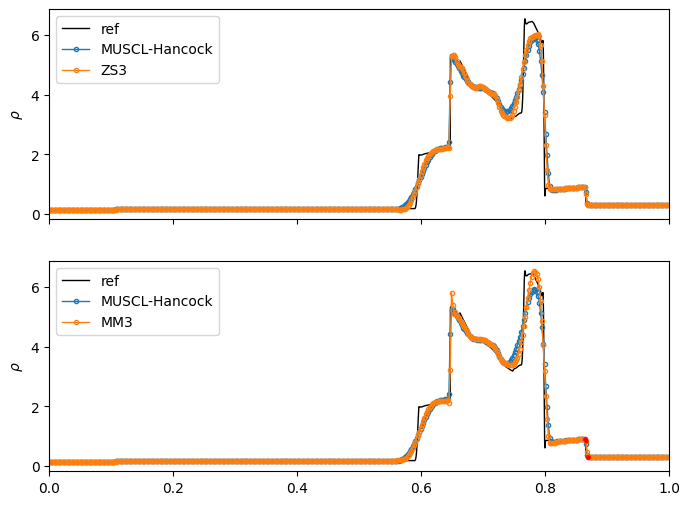

In [3]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

plot_1d_slice(sims["ref"], axs[0], "rho", label="ref", color="k", **style)
plot_1d_slice(sims["ref"], axs[1], "rho", label="ref", color="k", **style)

for name, sim in sims.items():
    if name == "ref":
        continue
    jlist = [0, 1] if name == "MUSCL-Hancock" else [1] if "MM" in name else [0]
    for j in jlist:
        plot_1d_slice(
            sim,
            axs[j],
            "rho",
            trouble_marker="o" if "MM" in name else None,
            label=name,
            marker="o",
            mfc="none",
            **style,
        )

axs[0].legend()
axs[1].legend()

axs[0].set_xlim(0, 1)

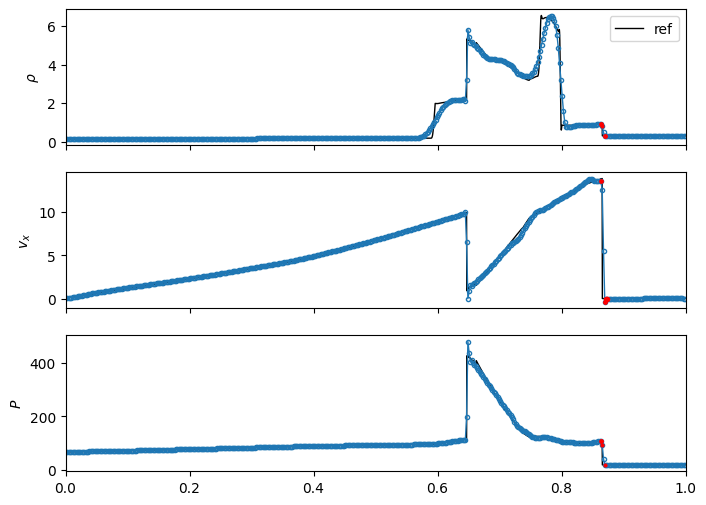

In [4]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(8, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")
axs[2].set_ylabel(r"$P$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

plot_1d_slice(sims["ref"], axs[0], "rho", label="ref", color="k", **style)
plot_1d_slice(sims["ref"], axs[1], "vx", label="ref", color="k", **style)
plot_1d_slice(sims["ref"], axs[2], "P", label="ref", color="k", **style)

sim = sims["MM3"]

plot_1d_slice(sim, axs[0], "rho", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[1], "vx", marker="o", mfc="none", trouble_marker="o", **style)
plot_1d_slice(sim, axs[2], "P", marker="o", mfc="none", trouble_marker="o", **style)


axs[0].legend()

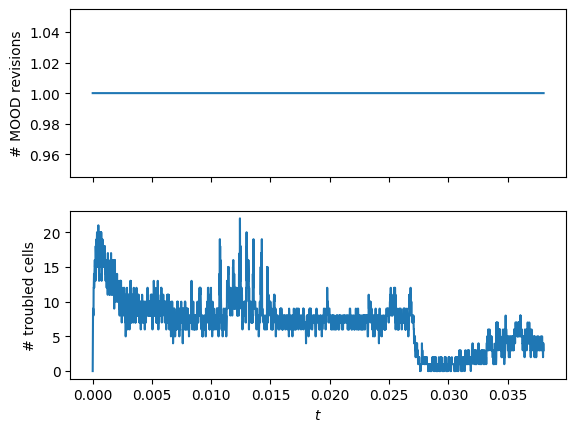

In [5]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].set_ylabel("# MOOD revisions")
axs[1].set_ylabel("# troubled cells")
axs[1].set_xlabel(r"$t$")

sim = sims["MM3"]

plot_timeseries(sim, axs[0], "nfine_MOOD_iters")
plot_timeseries(sim, axs[1], "nfine_troubles_vis_max")

(<matplotlib.image.AxesImage at 0x112ee2c90>,
 <matplotlib.colorbar.Colorbar at 0x112d339e0>)

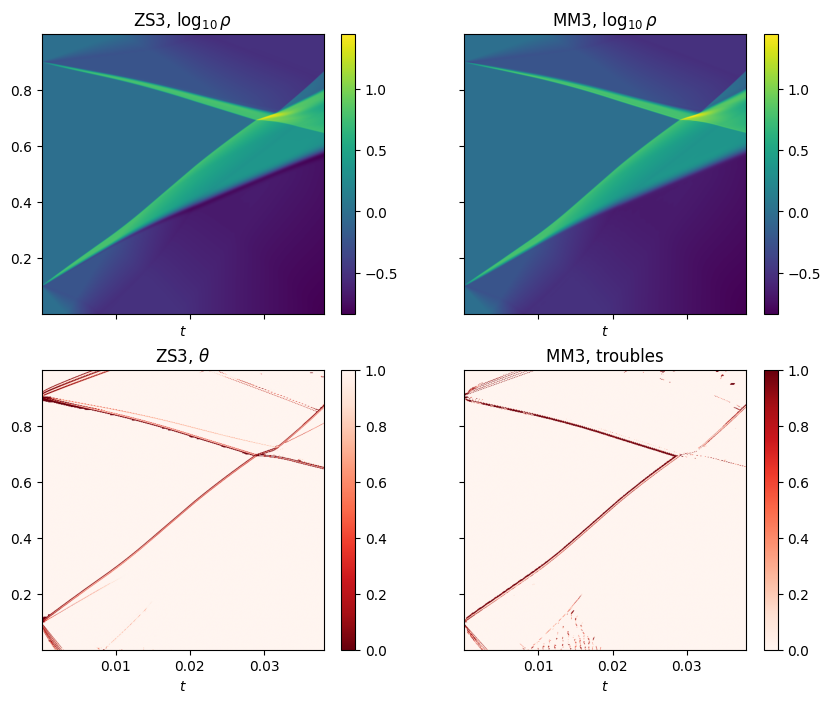

In [9]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
axs[0, 0].set_title(r"ZS3, $\log_{10} \rho$")
axs[0, 1].set_title(r"MM3, $\log_{10} \rho$")
axs[1, 0].set_title(r"ZS3, $\theta$")
axs[1, 1].set_title("MM3, troubles")

sim1 = sims["ZS3"]
sim2 = sims["MM3"]

vmin = min(
    np.log10(np.min(sim1.minisnapshots["min_rho"])),
    np.log10(np.max(sim2.minisnapshots["min_rho"])),
)
vmax = max(
    np.log10(np.max(sim1.minisnapshots["max_rho"])),
    np.log10(np.max(sim2.minisnapshots["max_rho"])),
)

rho_style = dict(
    cell_averaged=True, colorbar=True, func=lambda x: np.log10(x), vmin=vmin, vmax=vmax
)
plot_spacetime(sim1, axs[0, 0], "rho", **rho_style)
plot_spacetime(sim2, axs[0, 1], "rho", **rho_style)

plot_spacetime(sim1, axs[1, 0], "min", theta=True, colorbar=True, cmap="Reds_r")
plot_spacetime(sim2, axs[1, 1], "max", troubles=True, colorbar=True, cmap="Reds")